In [168]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from plotly import express as px

abw = pd.read_csv(
    "~/user/Downloads/20220425_084328.csv", parse_dates=True
).rename(columns={"Abwasser Täglich": "daily", "__timestamp": "date"}).set_index("date").filter(("daily",)).loc["2021-03-15":]
abw.index = pd.to_datetime(abw.index)
abw.index = abw.index.strftime("%Y-%m-%d")

wet = pd.read_csv("Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))

# rki
rki = pd.read_csv("Dresden_RKI_data.csv").set_index("Refdatum")
rki.rename(columns={"rki_7tage": "rki_7days", "rki_14tage": "rki_14days", "rki_28tage": "rki_28days"}, inplace=True)

# join
df = abw.join(rki).join(wet)
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")

# handle precipitation
df[f"daily"] = df.loc[df.prcp < 1, f"daily"]
# df = df.interpolate("time", axis=0)
df["sum_7days"] = df["daily"].rolling(7, min_periods=1, closed="left").mean() * 7
df["sum_14days"] = df["daily"].rolling(14, min_periods=1, closed="left").mean() * 7
df["sum_28days"] = df["daily"].rolling(28, min_periods=1, closed="left").mean() * 7

# style = {f"rki_{k}days": "k--" for k in (7, 14, 28)}
# style.update({k: "r" for k in ("sum_7days", "sum_14days", "sum_28days", "daily")})
# df.plot(figsize=(20,6), secondary_y=("sum_7days", "sum_14days", "sum_28days", "daily"), style=style)
# plt.savefig("verlauf.png")
# plt.show()
# px.line(df)
px.line(df/df.max())
# px.line(df, log_y=True)
# variants


In [182]:
def corr(x, y, w):
    import numpy as np

    def m(x, w):
        """Weighted Mean"""
        return np.nansum(x * w) / np.nansum(w)

    def cov(x, y, w):
        """Weighted Covariance"""
        return np.nansum(w * (x - m(x, w)) * (y - m(y, w))) / np.nansum(w)

    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


def get_lag(left, right, weights=None, method="pearson"):
    rng = range(-12, 12)
    rs = [corr(right.values, left.shift(lag).values, weights) for lag in rng]
    # rs = [right.corr(left.shift(lag), method=method) for lag in rng]
    rs = pd.DataFrame(rs, index=rng)
    return rs.idxmax()[0]


def shift(df, day, weights=None):
    lag = get_lag(df[f"rki_{day}days"], df[f"sum_{day}days"], weights)
    df[f"rki_{day}days"] = df[f"rki_{day}days"].shift(lag)
    return df, lag


# Linear regression
def get_lin_model(left, right, v):
    c, i = get_lin_coeff(left, right, v)
    return left * c + i


def get_lin_coeff(left, right, v):
    X = left.to_numpy().reshape(-1, 1)
    y = right.to_numpy().reshape(-1, 1)
    reg = LinearRegression().fit(X, y, sample_weight=v.loc[left.index])
    return reg.coef_[0][0], reg.intercept_[0]


def get_mse(left, right, v):
    w = v.loc[left.index]
    # d = (left - right).pow(2)
    d = ((left - right) * w).pow(2)
    # return (d * w).sum() / w.sum()
    return d.mean()

def autoscale_df(df):
    return (df - df.min()) / (df.max() - df.min())


In [170]:
# varianten
var = pd.read_csv("Dresden_Varianten.csv").set_index("DATE_DRAW")
# var = var.filter(("Alpha", "Delta", "Omicron"))
var = var.filter(("Alpha", "Delta", "BA.1", "BA.2"))
var.index = pd.to_datetime(var.index)
var = var.reindex(df.index)
var = var.interpolate("time", axis=0)
variants = {k: var[k] > 0.5 for k in var}


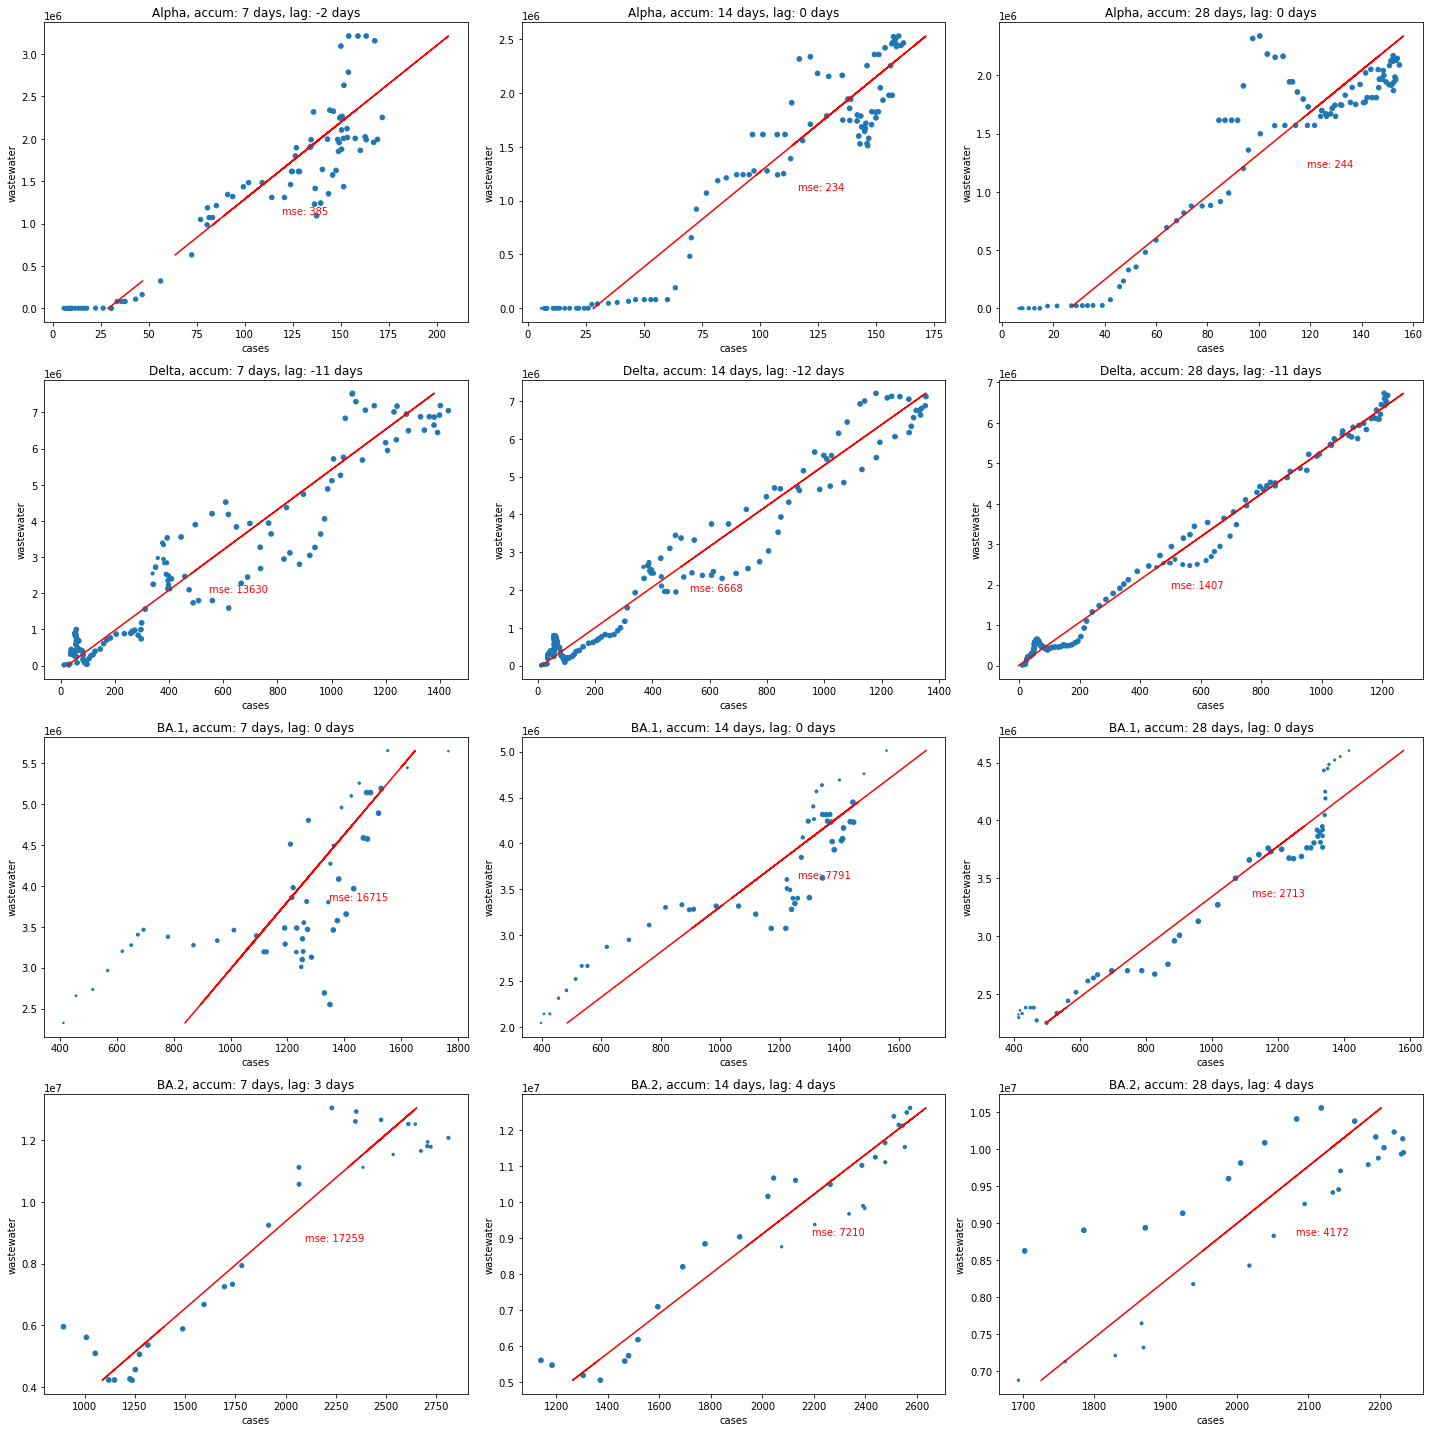

In [183]:
df_total = pd.DataFrame()
fig, axis = plt.subplots(
    len(variants), 3, figsize=(20, 5 * len(variants))  # , sharex=True, sharey=True
)
ci = {}
for w, v in enumerate(variants.keys()):
    df_shifted = df.loc[variants[v]].copy()
    ci[v] = {}
    for i, k in enumerate((7, 14, 28)):
        ax = axis[w, i]
        df_shifted, lag = shift(df_shifted, k, var[v].loc[df_shifted.index])
        df_shifted.plot.scatter(
            f"rki_{k}days",
            f"sum_{k}days",
            title=f"{v}, accum: {k} days, lag: {lag} days",
            ax=ax,
            ylabel="wastewater",
            xlabel="cases",
            s=autoscale_df(var[v].loc[df_shifted.index]) * 20 + 2,
        )
        df_tmp = df_shifted.filter((f"rki_{k}days", f"sum_{k}days")).dropna()
        df_shifted[f"pred_{k}"] = get_lin_model(
            df_tmp[f"sum_{k}days"], df_tmp[f"rki_{k}days"], var[v]
        )
        ci[v][k] = get_lin_coeff(df_tmp[f"sum_{k}days"], df_tmp[f"rki_{k}days"], var[v])
        df_shifted.plot.line(
            f"pred_{k}",
            f"sum_{k}days",
            ax=ax,
            legend=False,
            color="r",
            ylabel="wastewater",
            xlabel="cases",
        )

        # annotate mse
        mse = get_mse(df_shifted[f"pred_{k}"], df_shifted[f"rki_{k}days"], var[v])
        ax.annotate(
            f"mse: {mse:.0f}",
            (df_shifted[f"pred_{k}"].mean(), df_shifted[f"sum_{k}days"].mean()),
            xytext=(40, 0),
            textcoords="offset points",
            color="r",
        )
    df_total = pd.concat([df_total, df_shifted.copy()])

plt.tight_layout()
plt.savefig("correlation.png")
plt.show()


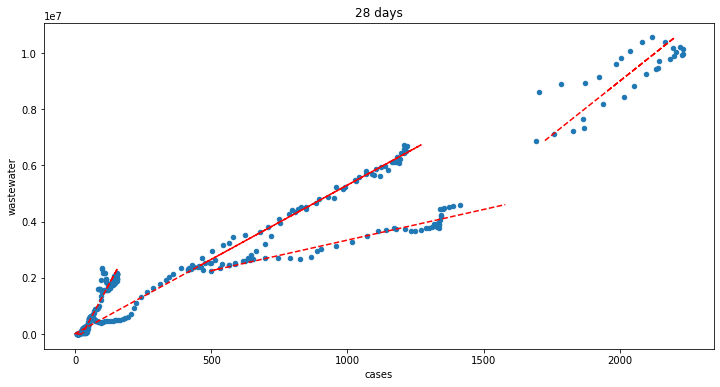

In [176]:
k = 28
ax = df_total.plot.scatter(f"rki_{k}days", f"sum_{k}days", figsize=(12, 6))
df_total.plot.line(
    f"pred_{k}", f"sum_{k}days", ax=ax, color="r", style="--", legend=False
)
plt.xlabel("cases")
plt.ylabel("wastewater")
plt.title(f"{k} days")
plt.savefig("correlation_total.png")
plt.show()


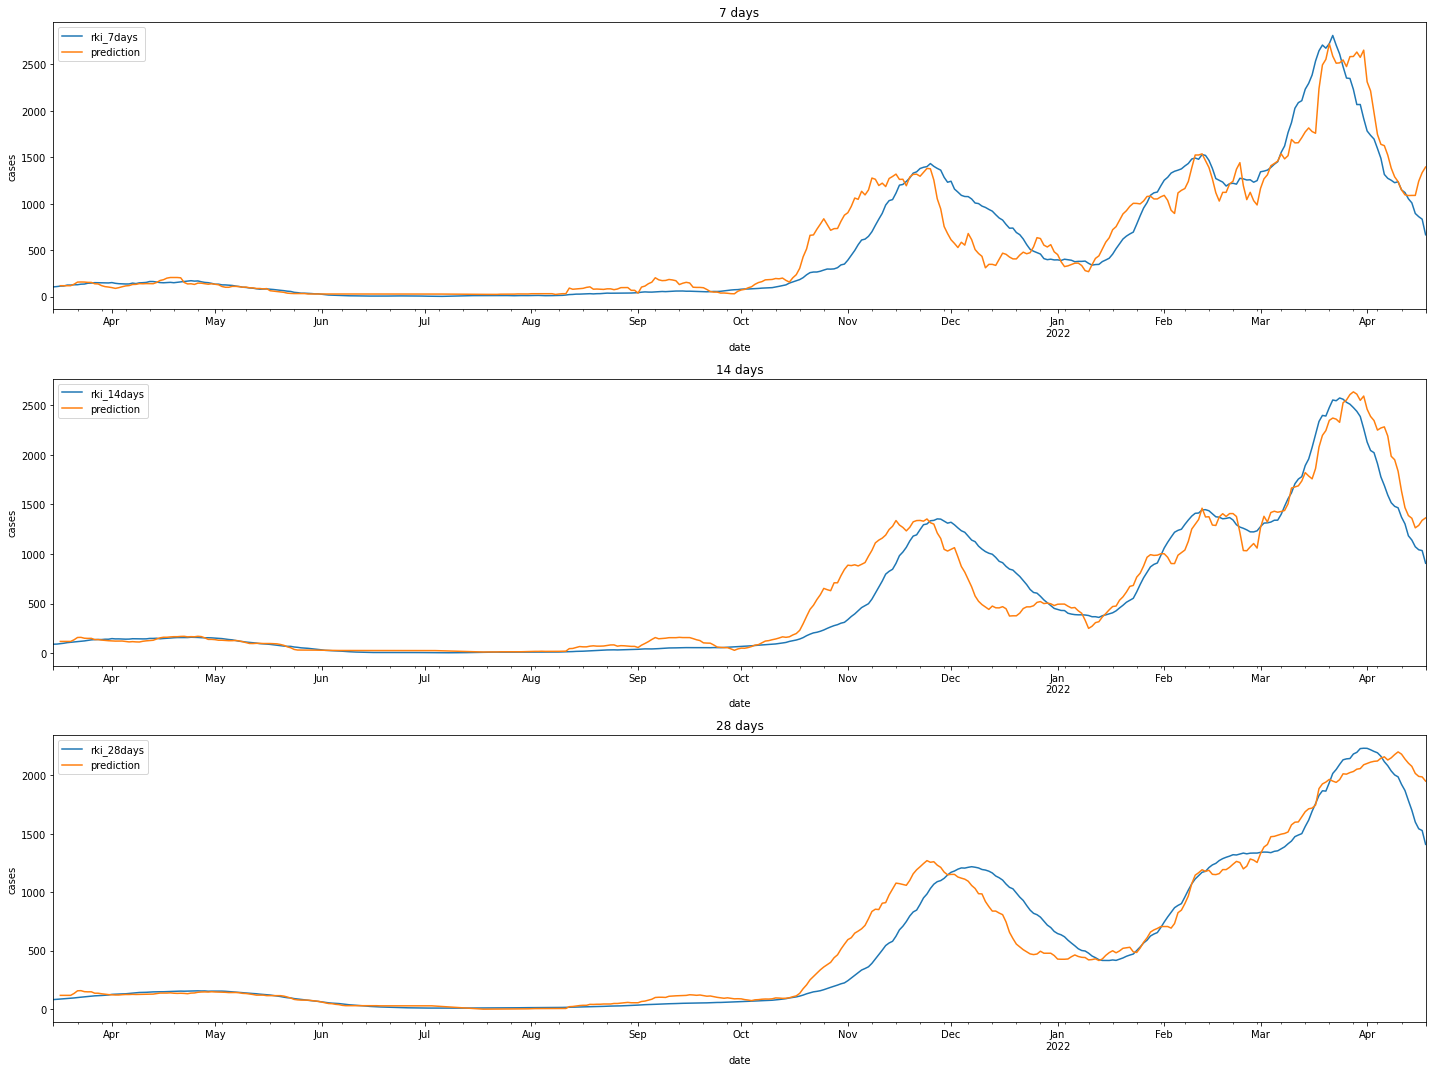

In [184]:
# total prediction
fig, axis = plt.subplots(3, 1, figsize=(20, 15))
for i, k in enumerate((7, 14, 28)):
    df_pred = df.filter(regex=f"{k}days").copy()
    for v in ci:
        df_pred.loc[var[v] > 0.6, "c"] = ci[v][k][0]
        df_pred.loc[var[v] > 0.6, "i"] = ci[v][k][1]
    df_pred.interpolate("time", axis=0, inplace=True)
    df_pred["prediction"] = df_pred[f"sum_{k}days"] * df_pred["c"] + df_pred["i"]
    df_pred.filter(regex=f"rki_{k}|pred").plot(title=f"{k} days", ax=axis[i], ylabel="cases")
plt.tight_layout()
plt.savefig("prediction.png")
plt.show()


In [185]:
px.line(df_total.filter(regex="rki|pred").resample("1D").sum())

In [116]:
# errors
for k in (7, 14, 28):
    print(f'{k:3}: {(df_total[f"rki_{k}days"] - df_total[f"pred_{k}"]).pow(2).mean():5.0f}')
# print(f'avg: {(df_total[f"rkiavg"] - df_total[f"predavg"]).pow(2).mean():5.0f}')

  7: 26356
 14: 15105
 28:  6548
